# Lab #1
___

**Task:** Build a Linear Regression model, using given dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from regression import LinearRegression
from bucket import Bucket
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression as skLR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

## Dataset reading and describing
___

_Dataset taken from:_ https://www.kaggle.com/mirichoi0218/insurance

In given dataset we will try to predict value of charges of person depending on given factors:

In [2]:
regions = ['southwest', 'southeast', 'northwest', 'northeast']
sex = ['male', 'female']
df = pd.read_csv("../datasets/insurance.csv", converters={
    "smoker": lambda val: 1 if val == "yes" else 0,
    "region": lambda val: regions.index(val),
    "sex": lambda val: sex.index(val),
})
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520


_Interesting observation:_ depending on age, charges separates on three different clusters. Let's divide it, and look on what we will get:

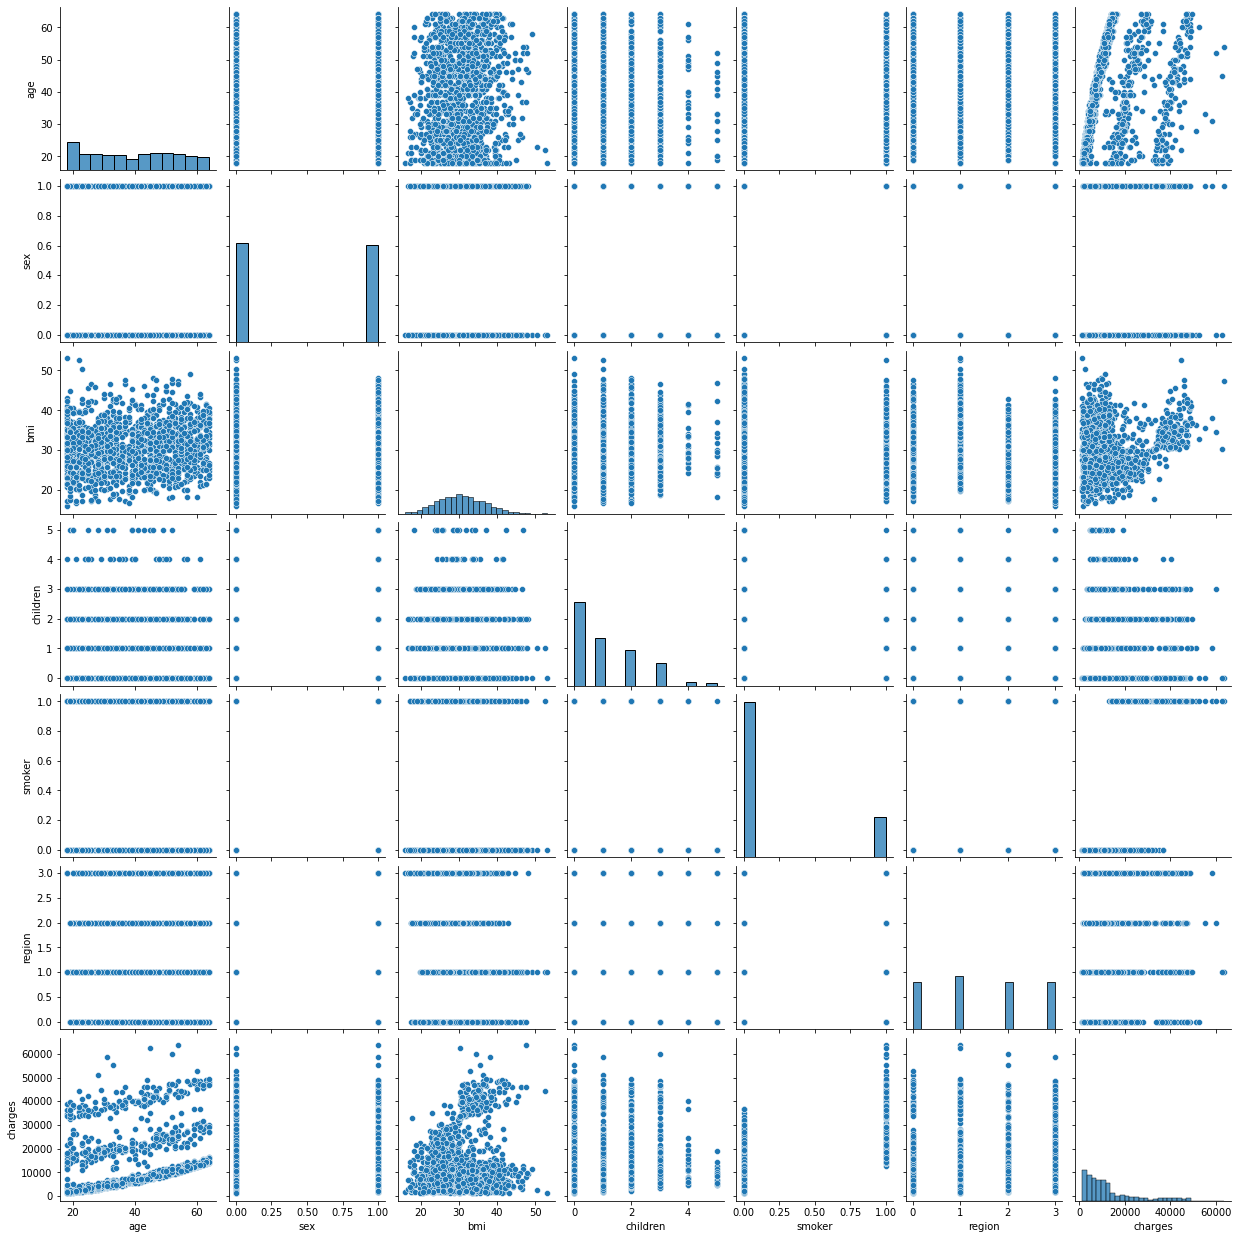

In [3]:
sns.pairplot(df)

## Clustering
___

Clustering of charges depending on age using dbscan:

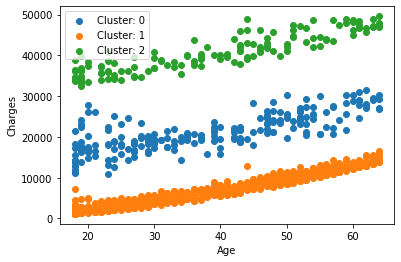

In [4]:
x = df[["age", "charges"]].to_numpy()
max_x = np.max(x, axis=0)
x = x / max_x
dbscan = DBSCAN(eps=.05, min_samples=5)
dbscan.fit(x)

clusters = []
for label in np.unique(dbscan.labels_):
    if label != -1:
        cluster = dbscan.labels_ == label
        clusters.append(cluster)
        cluster = x[cluster] * max_x
        plt.xlabel("Age")
        plt.ylabel("Charges")
        plt.scatter(cluster[:, 0], cluster[:, 1], label=f"Cluster: {label}")

plt.legend()

We also can see that points on scatter plot Charges(BMI) got quite reasonable clusterization too:

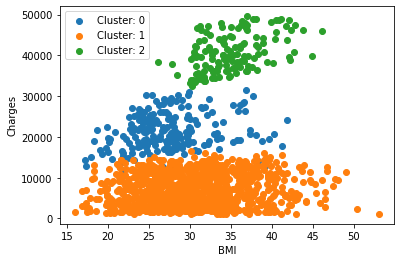

In [5]:
for label in range(len(clusters)):
    cluster = clusters[label]
    _x = df.loc[cluster, "bmi"]
    _y = df.loc[cluster, "charges"]

    plt.xlabel("BMI")
    plt.ylabel("Charges")
    plt.scatter(_x, _y, label=f"Cluster: {label}")
    
plt.legend()

## Next research
___

Let's take a closer look on cluster #1:

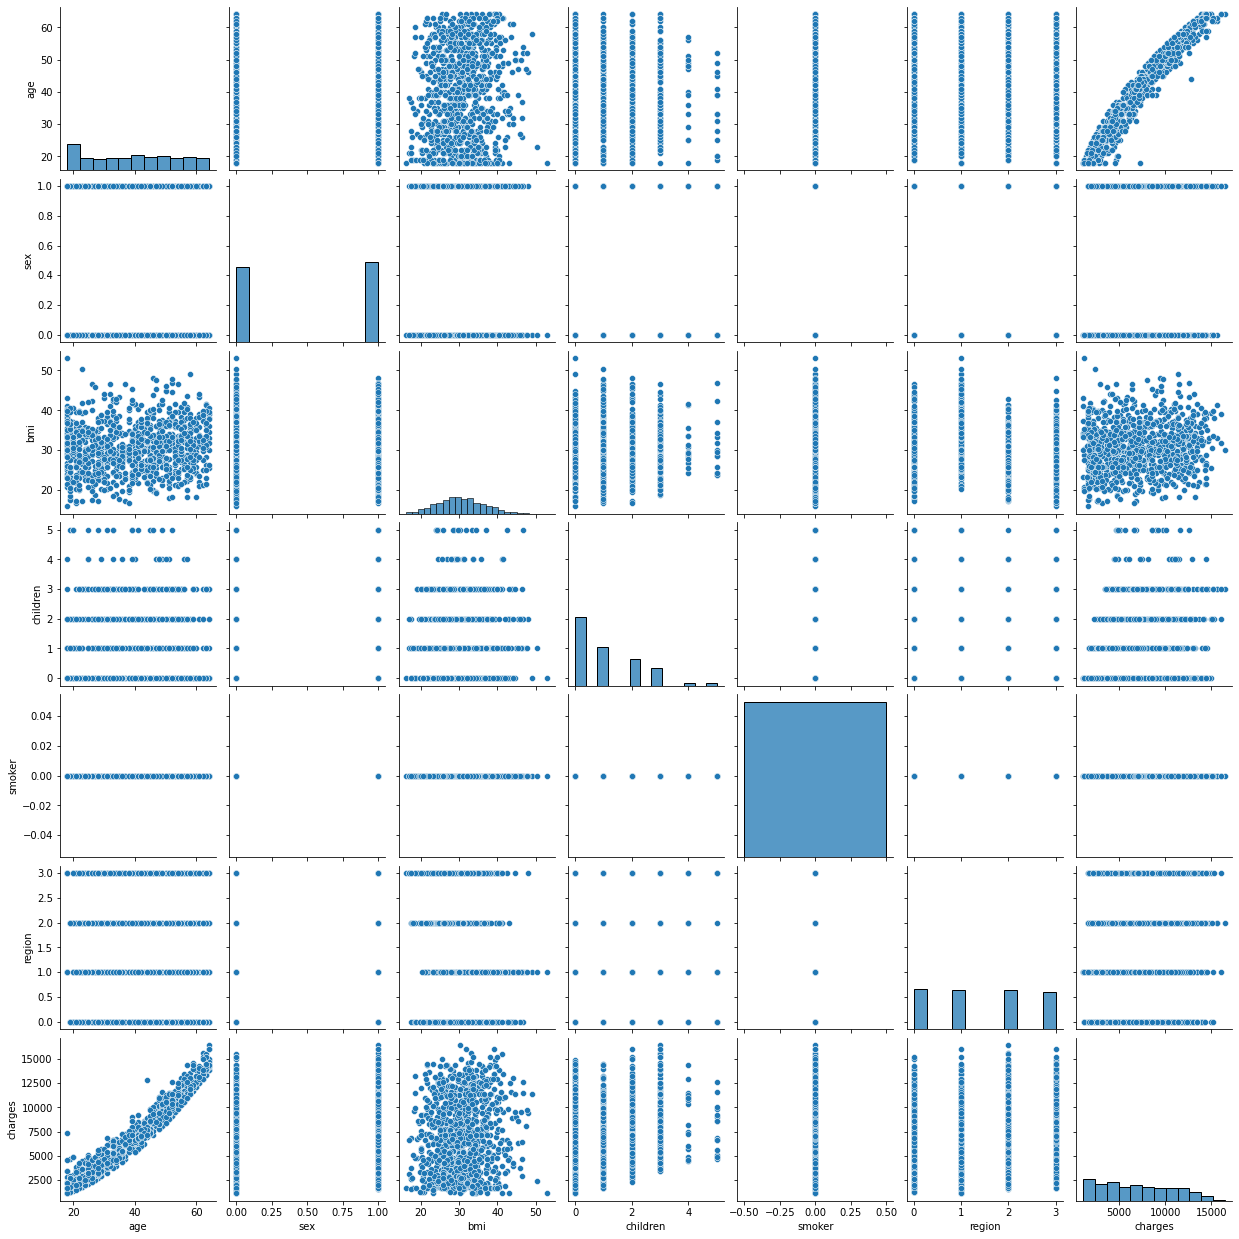

In [6]:
dataset = df.loc[clusters[1]]
dataset.reset_index(inplace=True, drop=True)
sns.pairplot(dataset)

Let's look on correlation of predictors and target variable:

In [7]:
dataset = dataset[["age", "bmi", "children", "region", "charges"]]
np.corrcoef(dataset.to_numpy().T).round(3)

array([[ 1.   ,  0.123,  0.036,  0.   ,  0.975],
       [ 0.123,  1.   ,  0.021, -0.159,  0.113],
       [ 0.036,  0.021,  1.   , -0.03 ,  0.168],
       [ 0.   , -0.159, -0.03 ,  1.   ,  0.061],
       [ 0.975,  0.113,  0.168,  0.061,  1.   ]])

As we see, 1 of 4 available predictors can help us. So let's choose only it:

In [8]:
dataset = dataset[["age", "charges"]]

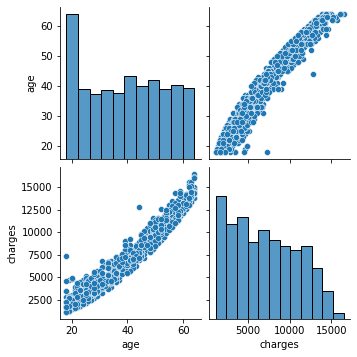

In [9]:
sns.pairplot(dataset)

## Anomaly detection
___

It become a little cleaner:

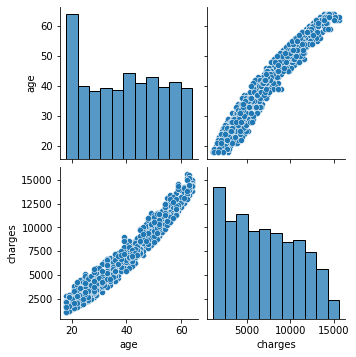

In [10]:
to_drop = []
for col in dataset.columns[:-1]:
    x = dataset[[col, dataset.columns[-1]]].to_numpy()
    x = x / np.max(x, axis=0)

    dbscan = DBSCAN(eps=.03, min_samples=5)
    dbscan.fit(x)
    to_drop = np.append(to_drop, np.argwhere(dbscan.labels_ == -1))

dataset = dataset.drop(np.unique(to_drop.astype(int)))
sns.pairplot(dataset)

## Data normalization
___
We will normalize data values by given formula: $$X = \frac{X - X_{min}}{X_{max} - X_{min}}$$

In [11]:
data = dataset.to_numpy()
min_vals = np.min(data, axis=0)
max_vals = np.max(data, axis=0)
data = (data - min_vals) / (max_vals - min_vals)
data

array([[0.        , 0.04166081],
       [0.2173913 , 0.22964215],
       [0.30434783, 0.18943553],
       ...,
       [0.        , 0.07481594],
       [0.        , 0.0350551 ],
       [0.06521739, 0.06114918]])

## Model fitting
___

We will train model type: $$Y = \omega_{0} + \omega_{1} * X$$

In [12]:
idxs = np.arange(0, len(dataset))
np.random.shuffle(idxs)

X = data[:, [0]]
Y = data[:, 1]

n = int(0.5 * len(dataset))

X_train = X[idxs[:n]]
Y_train = Y[idxs[:n]]

X_test = X[idxs[n:]]
Y_test = Y[idxs[n:]]

linregr = LinearRegression()
linregr.train(X_train, Y_train)

linregr.MSE(X_test, Y_test), linregr.score(X_test, Y_test), linregr.w

(0.0027565763065564275, 0.961751146987852, array([0.00886426, 0.85036711]))

### Lasso Regression:

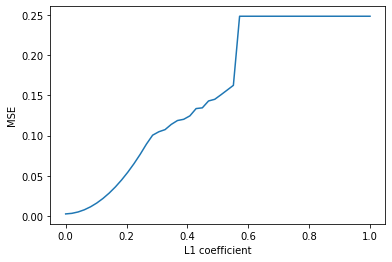

In [13]:
L1 = np.linspace(0, 1, 50)
mses = []
for l1 in L1:
    lr = LinearRegression(l1=l1)
    lr.train(X_train, Y_train)
    mses.append(lr.MSE(X_test, Y_test))
    
plt.xlabel("L1 coefficient")
plt.ylabel("MSE")
plt.plot(L1, mses)

In [14]:
linregr_l1 = LinearRegression(l1=.05)
linregr_l1.train(X_train, Y_train)

linregr_l1.MSE(X_test, Y_test), linregr_l1.score(X_test, Y_test), linregr_l1.w

(0.006264099128892086, 0.9130825414610692, array([0.05257469, 0.6988124 ]))

### Ridge Regression:

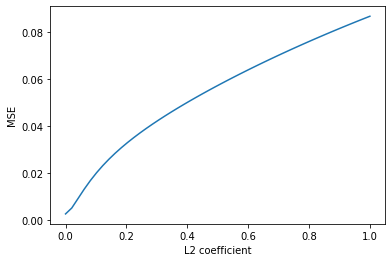

In [15]:
L2 = np.linspace(0, 1, 50)
mses = []
for l2 in L2:
    lr = LinearRegression(l2=l2)
    lr.train(X_train, Y_train)
    mses.append(lr.MSE(X_test, Y_test))
    
plt.xlabel("L2 coefficient")
plt.ylabel("MSE")
plt.plot(L2, mses)

In [16]:
linregr_l2 = LinearRegression(l2=.05)
linregr_l2.train(X_train, Y_train)

linregr_l2.MSE(X_test, Y_test), linregr_l2.score(X_test, Y_test), linregr_l2.w

(0.011067636028528787, 0.8464311027268547, array([0.13031617, 0.56810851]))

### Bucket of models:

In [17]:
weights = np.ones(3) / 3
bucket = Bucket([linregr, linregr_l1, linregr_l2], weights)

bucket.MSE(X_test, Y_test), bucket.score(X_test, Y_test)

(0.005313673516927998, 0.9262701646168409)

### Using sklearn library:

#### Ordinary Regression:

In [18]:
reg = skLR().fit(X_train, Y_train)
reg.score(X_test, Y_test), reg.coef_, reg.intercept_

(0.9617511473871856, array([0.8503671]), 0.008864275494181395)

#### Lasso Regression:

In [19]:
lasso_sk = Lasso(alpha=.05).fit(X_train, Y_train)
lasso_sk.score(X_test, Y_test), lasso_sk.coef_, lasso_sk.intercept_

(0.5430788766374731, array([0.29586097]), 0.2602609847150039)

#### Ridge Regression:

In [20]:
ridge_sk = Ridge(alpha=.05).fit(X_train, Y_train)
ridge_sk.score(X_test, Y_test), ridge_sk.coef_, ridge_sk.intercept_

(0.9617194453415677, array([0.84937763]), 0.009312869488378173)